In [56]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Cropping2D, Concatenate,ReLU
from tensorflow.keras.activations import sigmoid

import os, cv2, numpy as np, matplotlib.pyplot as plt

### UNet Contracting block
Perform two unpadded convolutions with a specified number of filters and downsample through max-pooling.

In [57]:
def contracting_block(input_layer, filters, padding, kernel_size = 3):
    conv = Conv2D(filters = filters,
                  kernel_size = kernel_size,
                  activation = 'relu',
                  padding = padding)(input_layer)

    conv = Conv2D(filters = filters,
                  kernel_size = kernel_size,
                  activation = 'relu',
                  padding = padding)(conv)

    pool = MaxPooling2D(pool_size = 2,
                        strides = 2)(conv)

    return conv, pool

### UNet Bottleneck block
Performs 2 unpadded convolutions with a specified number of filters.

In [25]:
def bottleneck_block(input_layer, filters, padding, kernel_size = 3, strides = 1):
    conv = Conv2D(filters = filters,
                  kernel_size = kernel_size,
                  padding = padding,
                  strides = strides,
                  activation = 'relu')(input_layer)

    conv = Conv2D(filters = filters,
                  kernel_size = kernel_size,
                  padding = padding,
                  strides = strides,
                  activation = 'relu')(conv)

    return conv

### UNet Expansive block
Center crops the source tensor to the size of the target tensor size. The tensor shape format is [batchsize, height, width, channels]

In [26]:
def crop_tensor(source_tensor, target_tensor):
    target_tensor_size = target_tensor.shape[2]
    source_tensor_size = source_tensor.shape[2]

    # calculate the delta to ensure correct cropping.
    delta = source_tensor_size - target_tensor_size
    delta = delta // 2

    return source_tensor[:, delta:source_tensor_size - delta, delta:source_tensor_size - delta, :]

### UNet Expansive block
Transpose convolution which doubles the spatial dimensions (height and width) 
of the incoming feature maps and creates the skip connections with the corresponding 
feature maps from the contracting (downsample) path. These skip connections bring the feature maps 
from earlier layers helping the network to generate better semantic feature maps.

Perform two unpadded convolutions with a specified number of filters 
and upsamples the incomming feature map.

In [35]:
def expansive_block(input_layer, skip_conn_layer, filters, padding, kernel_size = 3, strides = 1):
    transConv = Conv2DTranspose(filters = filters,
                                kernel_size = (2, 2),
                                strides = 2,
                                padding = padding)(input_layer)

    if padding == "valid":
        cropped = crop_tensor(skip_conn_layer, transConv)
        concat = Concatenate()([transConv, cropped])
    else:
        concat = Concatenate()([transConv, skip_conn_layer])

    # two 3x3 convolutions, each followed by a ReLU
    up_conv = Conv2D(filters = filters,
                     kernel_size = kernel_size,
                     padding = padding,
                     activation = 'relu')(concat)

    up_conv = Conv2D(filters = filters,
                     kernel_size = kernel_size,
                     padding = padding,
                     activation = 'relu')(up_conv)

    return up_conv

In [36]:
class Unet():
    def __init__(self, input_shape = (572, 572, 1), filters = [64, 128, 256, 512, 1024], padding = "valid"):
        """
        
        Initialize the Unet framework and the model parameters - input_shape, 
        filters and padding type. 
        
        Args:
            input_shape: The shape of the input to the network. A tuple comprising of (img_height, img_width, channels).
                         Original paper implementation is (572, 572, 1).
            filters: a collection of filters denoting the number of components to be used at each blocks along the 
                     contracting and expansive paths. The original paper implementation for number of filters along the 
                     contracting and expansive paths are [64, 128, 256, 512, 1024].
            padding: the padding type to be used during the convolution step. The original paper used unpadded convolutions 
                     which is of type "valid".
         
        **Remarks: The default values are as per the implementation in the original paper @ https://arxiv.org/pdf/1505.04597
        
        """
        self.input_shape = input_shape
        self.filters = filters
        self.padding = padding

    def Build_UNetwork(self):

        """
        Builds the Unet Model network.
        
        Args:
            None
         
        Return:
            The Unet Model.
            
        """


        UnetInput = Input(self.input_shape)

        # the contracting path. 
        # the last item in the filetrs collection points to the number of filters in the bottleneck block.
        conv1, pool1 = contracting_block(input_layer = UnetInput, filters = self.filters[0], padding = self.padding)
        conv2, pool2 = contracting_block(input_layer = pool1, filters = self.filters[1], padding = self.padding)
        conv3, pool3 = contracting_block(input_layer = pool2, filters = self.filters[2], padding = self.padding)
        conv4, pool4 = contracting_block(input_layer = pool3, filters = self.filters[3], padding = self.padding)

        # bottleneck block connecting the contracting and the expansive paths.
        bottleNeck = bottleneck_block(pool4, filters = self.filters[4], padding = self.padding)

        # the expansive path.
        upConv1 = expansive_block(bottleNeck, conv4, filters = self.filters[3], padding = self.padding)
        upConv2 = expansive_block(upConv1, conv3, filters = self.filters[2], padding = self.padding)
        upConv3 = expansive_block(upConv2, conv2, filters = self.filters[1], padding = self.padding)
        upConv4 = expansive_block(upConv3, conv1, filters = self.filters[0], padding = self.padding)

        UnetOutput = Conv2D(1, (1, 1), padding = self.padding, activation = sigmoid)(upConv4)

        model = Model(UnetInput, UnetOutput, name = "UNet")

        return model

    def CompileAndSummarizeModel(self, model, optimizer = "adam", loss = "binary_crossentropy"):

        """
        Compiles and displays the model summary of the Unet model.
        
        Args:
            model: The Unet model.
            optimizer: model optimizer. Default is the adam optimizer.
            loss: the loss function. Default is the binary cross entropy loss.
            
        Return:
            None
        
        """
        model.compile(optimizer = optimizer, loss = loss, metrics = ["acc"])
        model.summary()

    def plotModel(self, model, to_file = 'unet.png', show_shapes = True, dpi = 96):

        """
        Saves the Unet model to a file.
        
        Args:
            model: the Unet model. 
            to_file: the file name to save the model. Default name - 'unet.png'.
            show_shapes: whether to display shape information. Default = True.
            dpi: dots per inch. Default value is 96.
            
        Return:
            None
        
        """

        keras.utils.plot_model(model, to_file = to_file, show_shapes = show_shapes, dpi = dpi)

In [37]:
class NucleiDataGenerator(keras.utils.Sequence):

    """
    The custom data generator class generates and feeds data to
    the model dynamically in batches during the training phase.
    
    This generator generates batched of data for the dataset available @
    Find the nuclei in divergent images to advance medical discovery -
    https://www.kaggle.com/c/data-science-bowl-2018
    
    **
    tf.keras.utils.Sequence is the root class for 
    Custom Data Generators.
    **
    
    Args:
        image_ids: the ids of the image.
        img_path: the full path of the image directory.
        batch_size: no. of images to be included in a batch feed. Default is set to 8.
        image_size: size of the image. Default is set to 128 as per the data available.
        
    Ref: https://dzlab.github.io/dltips/en/keras/data-generator/
    
    """
    def __init__(self, image_ids, img_path, batch_size = 8, image_size = 128):

        self.ids = image_ids
        self.path = img_path
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()

    def __load__(self, item):

        """
        loads the specified image.
        
        """

        # the name for parent of parent directory where the image is located and the name of the image are same.
        # an example directory breakup is shown below -
        # - data-science-bowl-2018/
        #      - stage1_train/
        #          - abc
        #             - image
        #                  - abc
        #             - mask
        full_image_path = os.path.join(self.path, item, "images", item) + ".png"
        mask_dir_path = os.path.join(self.path, item, "masks/")
        all_masks = os.listdir(mask_dir_path)

        # load the images
        image = cv2.imread(full_image_path, 1)
        image = cv2.resize(image, (self.image_size, self.image_size))

        masked_img = np.zeros((self.image_size, self.image_size, 1))

        # load and prepare the corresponding mask.
        for mask in all_masks:
            fullPath = mask_dir_path + mask
            _masked_img = cv2.imread(fullPath, -1)
            _masked_img = cv2.resize(_masked_img, (self.image_size, self.image_size))
            _masked_img = np.expand_dims(_masked_img, axis = -1)
            masked_img = np.maximum(masked_img, _masked_img)

        # mormalize the mask and the image. 
        image = image/255.0
        masked_img = masked_img/255.0

        return image, masked_img

    def __getitem__(self, index):

        """
        Returns a single batch of data.
        
        Args:
            index: the batch index.
        
        """

        # edge case scenario where there are still some items left
        # after segregatings the images into batches of size batch_size.
        # the items left out will form one batch at the end.
        if(index + 1) * self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index * self.batch_size

        # group the items into a batch.
        batch = self.ids[index * self.batch_size : (index + 1) * self.batch_size]

        image = []
        mask  = []

        # load the items in the current batch
        for item in batch:
            img, masked_img = self.__load__(item)
            image.append(img)
            mask.append(masked_img)

        image = np.array(image)
        mask  = np.array(mask)

        return image, mask

    def on_epoch_end(self):

        """
        optional method to run some logic at the end of each epoch: e.g. reshuffling
        
        """

        pass

    def __len__(self):

        """
        Returns the number of batches
        """
        return int(np.ceil(len(self.ids)/float(self.batch_size)))


In [38]:
image_size = 256
image_channels = 3
image_dir = "data/train/"
epochs = 20
batch_size = 8

# there are a total of 670 items at the train_path directory.
# so fixing 600 of data available for training set
# 50 for validation set and 20 for test set.
validation_data_size = 50
test_data_size = 20
train_data_size = 600

In [39]:
def VisualizeImageAndMask(image, mask, prediction_img = None):

    """
    
    Displays the image, mask and the predicted mask
    of the input image.
    
    Args:
        image: the original image.
        mask: the given mask of the image.
        prediction_img: the predicted mask of the image.
        
    Return:
        None
        
    """
    fig = plt.figure()
    fig.subplots_adjust(hspace = 0.6, wspace = 0.6)
    fig.suptitle('Image & Mask(s)', fontsize = 15)
    fig.subplots_adjust(top = 1.15)

    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(image)
    setTitleAndRemoveTicks(ax, 'Microscopic\nImage')

    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(np.reshape(mask, (image_size, image_size)), cmap = "gray")
    setTitleAndRemoveTicks(ax, 'Original\nMask')

    if prediction_img is not None:
        ax = fig.add_subplot(1, 3, 3)
        ax.imshow(np.reshape(prediction_img, (image_size, image_size)), cmap = "gray")
        setTitleAndRemoveTicks(ax, 'Predicted\nMask')

def setTitleAndRemoveTicks(axes, title):

    """
    Sets the sub-plot title and removes the 
    x & y ticks on the respective axes.
    
    Args:
        axes: the subplot.
        title: title of the subplot.
        
    Return:
        None
        
    """

    # set plot title
    axes.title.set_text(title)

    # remove the ticks
    axes.set_xticks([])
    axes.set_yticks([])

In [40]:
# get the ids of the images.
# os.walk yields a 3-tuple (dirpath, dirnames, filenames). We need the directory names here.
# the name for parent of parent directory where the image is located and the name of the image are same.
# an example directory breakup is shown below -
# - data-science-bowl-2018/
#      - stage1_train/
#          - abc
#             - image
#                  - abc
#             - mask
image_ids = next(os.walk(image_dir))[1]

# partition the data into train, test and validation sets.
testing_data_ids = image_ids[:test_data_size]
validation_data_ids = image_ids[:validation_data_size]
training_data_ids = image_ids[:train_data_size]

In [41]:
temp_data_generator = NucleiDataGenerator(image_ids = training_data_ids,
                                          img_path = image_dir,
                                          batch_size = batch_size,
                                          image_size = image_size)

# get one batch of data
images, masks = temp_data_generator.__getitem__(0)
print("Batch Dimension Details:", images.shape, masks.shape)

Batch Dimension Details: (8, 256, 256, 3) (8, 256, 256, 1)


In [42]:
unet = Unet(input_shape = (image_size, image_size, image_channels),
            filters = [16, 32, 64, 128, 256],
            padding = "same")

# call the build netowrk API to build the network.
model = unet.Build_UNetwork()

In [43]:
# compile & summarize the model
if model is not None:
    unet.CompileAndSummarizeModel(model = model)

Model: "UNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_11 (Conv2D)          (None, 256, 256, 16)         448       ['input_3[0][0]']             
                                                                                                  
 conv2d_12 (Conv2D)          (None, 256, 256, 16)         2320      ['conv2d_11[0][0]']           
                                                                                                  
 max_pooling2d_4 (MaxPoolin  (None, 128, 128, 16)         0         ['conv2d_12[0][0]']           
 g2D)                                                                                          

In [44]:
train_gen = NucleiDataGenerator(image_ids = training_data_ids,
                                img_path = image_dir,
                                image_size = image_size,
                                batch_size = batch_size)

valid_gen = NucleiDataGenerator(image_ids = validation_data_ids,
                                img_path = image_dir,
                                image_size = image_size,
                                batch_size = batch_size)

test_gen = NucleiDataGenerator(image_ids = testing_data_ids,
                               img_path = image_dir,
                               image_size = image_size,
                               batch_size = batch_size)

train_steps = len(training_data_ids)//batch_size
valid_steps = len(validation_data_ids)//batch_size

### Model Training

In [45]:
model.fit(train_gen,
          validation_data = valid_gen,
          steps_per_epoch = train_steps,
          validation_steps = valid_steps,
          epochs = epochs)

Epoch 1/20
75/75 [==============================] - 45s 592ms/step - loss: 0.3711 - acc: 0.8513 - val_loss: 0.2574 - val_acc: 0.8521
Epoch 2/20
75/75 [==============================] - 43s 576ms/step - loss: 0.2167 - acc: 0.8809 - val_loss: 0.1690 - val_acc: 0.9231
Epoch 3/20
75/75 [==============================] - 45s 600ms/step - loss: 0.1368 - acc: 0.9386 - val_loss: 0.1364 - val_acc: 0.9268
Epoch 4/20
75/75 [==============================] - 48s 631ms/step - loss: 0.0995 - acc: 0.9547 - val_loss: 0.1293 - val_acc: 0.9329
Epoch 5/20
75/75 [==============================] - 46s 608ms/step - loss: 0.0910 - acc: 0.9585 - val_loss: 0.0924 - val_acc: 0.9553
Epoch 6/20
75/75 [==============================] - 45s 598ms/step - loss: 0.0936 - acc: 0.9576 - val_loss: 0.1352 - val_acc: 0.9360
Epoch 7/20
75/75 [==============================] - 45s 602ms/step - loss: 0.0895 - acc: 0.9589 - val_loss: 0.0929 - val_acc: 0.9538
Epoch 8/20
75/75 [==============================] - 45s 592ms/step - 

### Model Testing and Prediction Visualizations

1/1 [==============================] - 0s 166ms/step


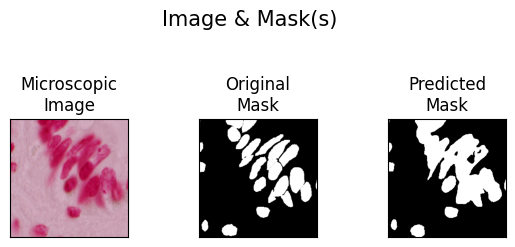

In [51]:
# get the test set images
test_images, test_masks = test_gen.__getitem__(1)
predicted_masks = model.predict(test_images)

predicted_masks = predicted_masks > 0.5

VisualizeImageAndMask(image = test_images[1], mask = test_masks[1], prediction_img = predicted_masks[1])


In [54]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_gen)
print("test loss, test acc:", results)

Evaluate on test data
5/5 [==============================] - 1s 153ms/step - loss: 0.0501 - acc: 0.9724
test loss, test acc: [0.05010734125971794, 0.9723861813545227]
